# EDS 220 Fall 2022
# Intro to map projections in Cartopy

(some portions of this notebook are adapted from https://earth-env-data-science.github.io/lectures/mapping_cartopy.html)

<img src="attachment:34b43d37-7b92-4140-8de1-e70b23f2f3d5.png"  width=30% height=30%>

All two-dimensional visualizations of geospatial data require the use of some form of _map projection_ in order to translate information collected on the three-dimensional Earth into a flat plane. In Python, the `cartopy` package is an excellent way to accomplish this. Cartopy features include:
- an extensive library of map projections and coordinate reference systems
- easy interfacing with Numpy for calculations, and Matplotlib for creating high-quality maps

The full list of available map projections in Cartopy can be found at:

https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html#cartopy-projections

### 1) Map projections in Cartopy

To get started, first we need to import the Cartopy package. Usually, the Cartopy coordinate system module `crs` is imported directly, to make it easier to call this module later. The most common name for this module is `ccrs` (Cartopy Coordinate Reference System):

In [1]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr

Let's take a look at a couple of projection _objects_ to get a feel for them. This can be accomplished by referencing the name of the projection within `ccrs`. For instance, to make a Plate-Carree projection object:

In [2]:
ccrs.PlateCarree()

<Derived Projected CRS: +proj=eqc +ellps=WGS84 +a=6378137.0 +lon_0=0.0 +to ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (unknown)
- N[north]: Northing (unknown)
- h[up]: Ellipsoidal height (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Equidistant Cylindrical
Datum: unknown
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Just for some contrast, here is an example of the Albers equal-area projection:

In [3]:
ccrs.AlbersEqualArea()

<Derived Projected CRS: +proj=aea +ellps=WGS84 +lon_0=0.0 +lat_0=0.0 +x_0= ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Albers Equal Area
Datum: Unknown based on WGS84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

You can display information about the projection classes using the `?` syntax:

In [4]:
ccrs.PlateCarree?

### 2) Plotting map data: GeoAxes

Cartopy interfaces quite nicely with Matplotlib, to allow all the functionality of normal Matplotlib plotting with additional features that are highly useful for plotting geospatial data. To take advantage of this, the procedure is to create a plot using the [cartopy.mpl.geoaxes.GeoAxes](https://scitools.org.uk/cartopy/docs/latest/reference/generated/cartopy.mpl.geoaxes.GeoAxes.html) format for the axes. This will allow Matplotlib to plot the projected data in the appropriate (x,y) location on the plot.

The below code chunk creates a blank GeoAxes object using the PlateCarree projection, then draws coastline outlines on it:

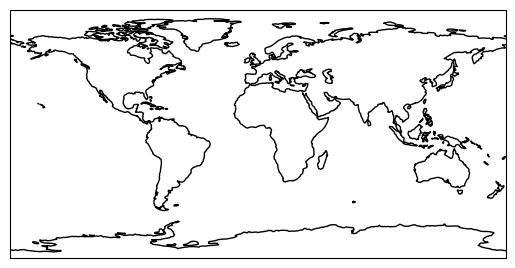

In [5]:
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

Now rather than a view of the entire globe, often you'll want to be making maps for a selected region of interest. To zoom in, you can use the `set_extent` method available within GeoAxis. As an example, the code below displays the western United States:

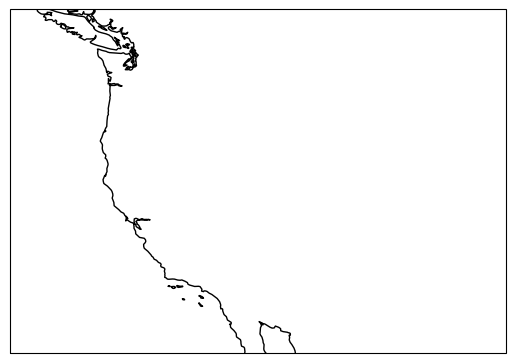

In [6]:
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-100,-130,30,50])
ax.coastlines()

To make this map more useful, one might want to do things like adding in state boundaries. Cartopy makes this extremely easy through its available built-in [features](https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html):

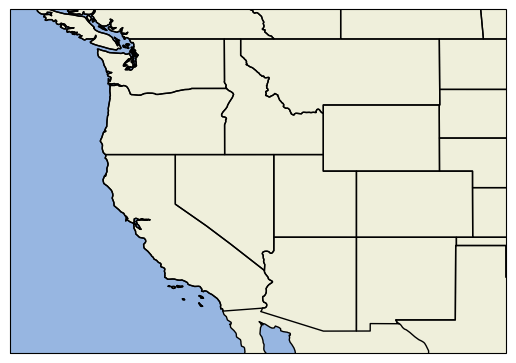

In [7]:
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-100,-130,30,50])   # set lon/lat range for the western US
ax.coastlines()

# Add coloring for ocean
ax.add_feature(cartopy.feature.OCEAN)
# Add coloring for land
ax.add_feature(cartopy.feature.LAND)
# Add state boundaries
ax.add_feature(cartopy.feature.STATES)

### 3) Add data to a map projection plot

Now that we're somewhat familiar with the projection handling in Cartopy, the next step is to actually plot some data! Here we'll take advantage of OpeNDAP once again, and read in data from the NOAA CPC Merged Analysis of Precipitation (CMAP) precipitation dataset:

https://psl.noaa.gov/data/gridded/data.cmap.html

In [7]:
# Open CMAP precipitation file using OpeNDAP
#cmap=xr.open_dataset("https://psl.noaa.gov/thredds/dodsC/Datasets/cmap/enh/precip.mon.mean.nc")
cmap = xr.open_dataset("https://psl.noaa.gov/thredds/dodsC/Datasets/cmap/enh/precip.mon.mean.nc")


In [8]:
# Display header information and metadata
cmap

<xarray.Dataset>
Dimensions:  (lat: 72, lon: 144, time: 525)
Coordinates:
  * lat      (lat) float32 88.75 86.25 83.75 81.25 ... -83.75 -86.25 -88.75
  * lon      (lon) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-09-01
Data variables:
    precip   (time, lat, lon) float32 ...
Attributes:
    Conventions:                     COARDS
    title:                           CPC Merged Analysis of Precipitation (in...
    platform:                        Analyses
    source:                          ftp ftp.cpc.ncep.noaa.gov precip/cmap/mo...
    dataset_title:                   CPC Merged Analysis of Precipitation
    documentation:                   https://www.esrl.noaa.gov/psd/data/gridd...
    date_modified:                   26 Feb 2019
    References:                      https://www.psl.noaa.gov/data/gridded/da...
    version:                         V2210
    history:                         update 10/2022 V2210
    data_modified:                   2022-10-07
    DODS_EXTRA.Unlimited_Dimension:  time

Taking a look through the metadata, we see that this file contains monthly averages of precipitation from 1979 to 2022. To get a reasonable set of values to plot, we can take the time average of the CMIP precipitation array:

In [9]:
# Take average along first dimension (axis = 0); time
mean_precip = cmap.precip.mean("time")

Now to plot this array, we use the same commands as above to create the figure object, GeoAxes, and map projection transformation... but then add a filled contour (`contourf`) plot with the values of mean precipitation from CMAP.

__***IMPORTANT NOTE: when plotting into a set of GeoAxes, you must make sure that the coordinate system of the data is the same as the coordinate system of the axes!***__

We ensure that coordinates are correct when plotting data using the `transform=ccrs.PlateCarree()` option within the contourf command below (obviously, if we were using a different map projection we would replace "PlateCarree" with the name of the other projection).

We can also add a color bar to help interpret the results; below, this is accomplished by assigning the contour plot object generated by `ax.contourf` to a variable, and providing that variable in turn to the Matplotlib colorbar command `plt.colorbar`.

Here I have chosen the 'Greens' colormap; other colormaps are available here:

https://matplotlib.org/stable/tutorials/colors/colormaps.html

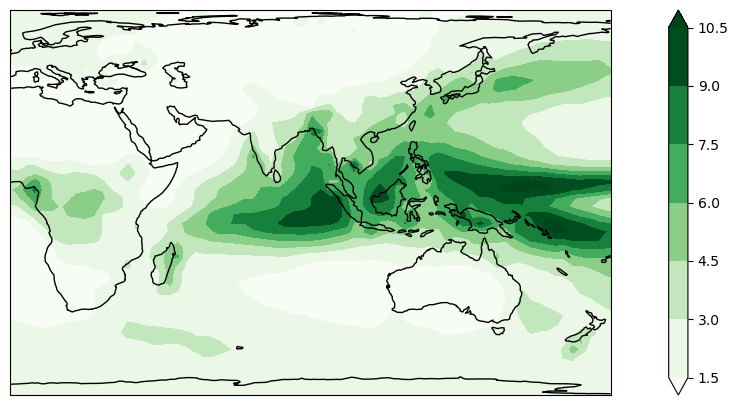

In [20]:
fig = plt.figure(figsize=(15, 5))
ax = plt.axes(projection=ccrs.LambertCylindrical())
#ax.set_extent([-180,180,-90,90])   # change region of interest if desired
ax.coastlines()  # add coastlines

# Add coloring for ocean
ax.add_feature(cartopy.feature.OCEAN)
# Add state boundaries
ax.add_feature(cartopy.feature.STATES)

# Add precipitation data
cf = ax.contourf(cmap.lon, cmap.lat, mean_precip, transform=ccrs.LambertCylindrical(), cmap='Greens', extend="both", vmax=10)

# Add colorbar
fig.colorbar(cf,ax=ax)

Now let's try changing the projection to see how this affects our displayed data! To do this, we need to change the projection used in the GeoAxes object.

__**ANOTHER IMPORTANT NOTE: to reproject data, we change the projection of the AXES - *not* the projection of the data!**__

The CMAP dataset unfortunately does not list the coordinate system in which it was created in the metadata, as far as I could tell. However, we can assume that PlateCarree is a reasonable choice, since the map above looks accurate. We will therefore *leave* the transform associated with the CMAP contourf object the same (`transform=ccrs.PlateCarree()`), and *change* the projection associated with the axes object to Mercator (`projection=ccrs.Mercator())` in the example below:

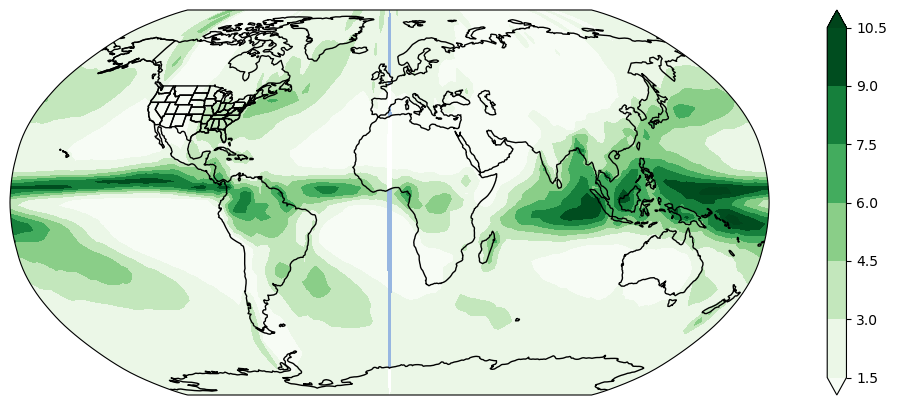

In [21]:
fig = plt.figure(figsize=(15, 5))
ax = plt.axes(projection=ccrs.Robinson())
#ax.set_extent([-180,180,-90,90])   # change region of interest if desired
ax.coastlines()  # add coastlines

# Add coloring for ocean
ax.add_feature(cartopy.feature.OCEAN)
# Add state boundaries
ax.add_feature(cartopy.feature.STATES)

# Add precipitation data
cf = ax.contourf(cmap.lon, cmap.lat, mean_precip, transform=ccrs.LambertCylindrical(), cmap='Greens', extend="both", vmax=10)

# Add colorbar
fig.colorbar(cf,ax=ax)

### 4) Map projections: your turn!

After going through this notebook, see if you can re-run the code doing the following:

- Changing the map projection to another choice from the [list of Cartopy projections](https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html#cartopy-projections)
- Changing the region of interest